# Room Occupancy Count Classifier Prediction
Author: Andy Malinsky

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Bidirectional, GRU, Dense, Input, Dropout
from sklearn.utils.class_weight import compute_class_weight
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns

# Setting seed for reproducibility
np.random.seed(24)

## Load and Prepare Data

In [3]:
# Load dataset
ro_data = pd.read_pickle("ro_data.pkl")
ro_data.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,...,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,Datetime,time_diff,is_large_gap,group
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,...,0.06,390,0.769231,0,0,1,2017-12-22 10:49:41,NaT,False,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,...,0.06,390,0.646154,0,0,1,2017-12-22 10:50:12,0 days 00:00:31,False,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,...,0.06,390,0.519231,0,0,1,2017-12-22 10:50:42,0 days 00:00:30,False,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,...,0.09,390,0.388462,0,0,1,2017-12-22 10:51:13,0 days 00:00:31,False,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,...,0.06,390,0.253846,0,0,1,2017-12-22 10:51:44,0 days 00:00:31,False,1


In [4]:
# Using the second half of group 1 as testing data because it has a good distribution of occupancy counts
group_1_data = ro_data[ro_data['group'] == 1]
split_index = len(group_1_data) // 2  # Midpoint of group 1

# Define training and testing sets
test_data = group_1_data.iloc[split_index:]  # Second half of group 1 as test set
train_data = ro_data[~ro_data.index.isin(test_data.index)]  # All other data as training set

# Features selected based on correlation analysis in eda-data-clean.ipynb notebook
filtered_columns = [
    'S1_Temp', 'S1_Light', 
    'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
    'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR',
]
target_column = ['Room_Occupancy_Count']
num_classes = len(ro_data['Room_Occupancy_Count'].unique())

X_train, y_train = train_data[filtered_columns], train_data[target_column]
X_test, y_test = test_data[filtered_columns], test_data[target_column]

# Display the new training and test set sizes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7476, 10), (2653, 10), (7476, 1), (2653, 1))

In [5]:
# View Room Occupancy Count Distributions
counts_train = pd.DataFrame(y_train)
counts_test = pd.DataFrame(y_test)
train_counts = counts_train.value_counts().rename('train_occupancy_count')
test_counts = counts_test.value_counts().rename('test_occupancy_count')
value_counts_df = pd.concat([train_counts, test_counts], axis=1, sort=False).fillna(0)
value_counts_df.transpose()

Room_Occupancy_Count,0,3,2,1
train_occupancy_count,6357,564,350,205
test_occupancy_count,1871,130,398,254


In [6]:
# Create sequences for GRU model
def create_sequences(x_data, y_data, seq_length):
    seq_arrays = []
    seq_labs = []
    
    for start in range(0, len(x_data) - seq_length):
        seq_arrays.append(x_data[start:start + seq_length])
        seq_labs.append(y_data[start + seq_length - 1])

    # Convert to numpy arrays and floats for keras layers      
    seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
    seq_labs = np.array(seq_labs, dtype = object).astype(np.float32) 
    
    return seq_arrays, seq_labs

In [7]:
# Create sequences for model input
seq_length = 5 # define sequence length

X_train_seq, y_train_seq = create_sequences(X_train, y_train.values, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test.values, seq_length)
X_train_seq.shape, y_train_seq.shape, X_test_seq.shape, y_test_seq.shape

((7471, 5, 10), (7471, 1), (2648, 5, 10), (2648, 1))

## Model Training

In [8]:
# View Input Shape
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
input_shape

(5, 10)

In [9]:
# Create a Bidirectional GRU model
def create_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Bidirectional(GRU(64, return_sequences=True, recurrent_dropout=0.2)),
        Bidirectional(GRU(32, recurrent_dropout=0.2)),
        Dropout(0.3),
        Dense(units=num_classes, activation='softmax')
    ])

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Create model instance and view model summary
model = create_model(input_shape=input_shape, num_classes=num_classes)
model.summary()

# To prevent overfitting on imbalanced classes, calculate balanced class weights
y_train_labels = y_train_seq.astype(int).reshape(-1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_seq), y=y_train_labels)
class_weights_train = dict(zip(np.unique(y_train_seq), class_weights))

classifier = KerasClassifier(model=model, random_state=24,
                        epochs=10, batch_size=32, verbose=0, class_weight=class_weights_train)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 5, 128)         │        29,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,548 (236.52 KB)

 Trainable params: 60,548 (236.52 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Run Grid Search with TimeSeries Cross Validation
tscv = TimeSeriesSplit(n_splits=3) 
param_grid = {'epochs': [10, 25], 'batch_size': [64, 256]}

grid_search = GridSearchCV(classifier, param_grid, cv=tscv, scoring='f1_macro')
grid_search.fit(X_train_seq, y_train_seq)
best_classifier = grid_search.best_estimator_

# Print the best parameters and score
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)
print('Average cross-validation F1-score (macro)', grid_search.cv_results_['mean_test_score'])

c:\Users\zuzal\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best parameters: {'batch_size': 256, 'epochs': 10}
Best score: 0.6380867100297078
Average cross-validation F1-score (macro) [0.63763441 0.63683391 0.63808671 0.62405783]


In [11]:
# Train the model with the best classifer parameters
classifier.epochs = best_classifier.epochs
classifier.batch_size = best_classifier.batch_size
history = classifier.fit(X_train_seq, y_train_seq)

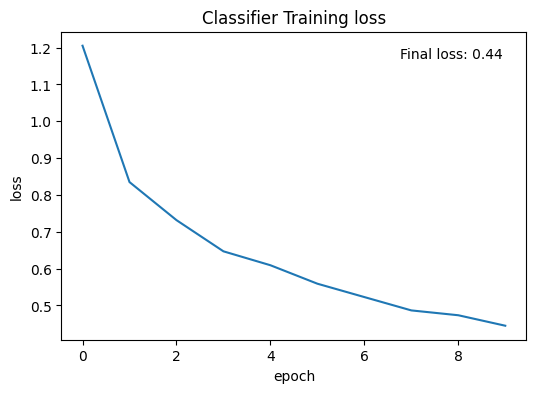

In [12]:
# Summarize history for Loss
fig_acc = plt.figure(figsize=(6,4))
plt.plot(history.history_['loss'])
plt.title('Classifier Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.text(0.95, 0.95, 'Final loss: '+str(round(history.history_['loss'][-1], 2)),
         horizontalalignment='right',
         verticalalignment='top',
         transform=plt.gca().transAxes)
plt.show()

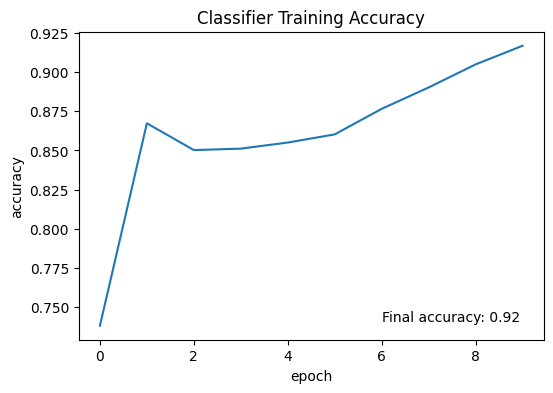

In [13]:
# Summarize history for Accuracy
fig_acc = plt.figure(figsize=(6, 4))
plt.plot(history.history_['accuracy'])
plt.title('Classifier Training Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.text(0.95, 0.05, 'Final accuracy: '+str(round(history.history_['accuracy'][-1], 2)),
         horizontalalignment='right',
         verticalalignment='bottom',
         transform=plt.gca().transAxes)
plt.show()

In [14]:
# Evaluate the model on the test set
y_pred_test = classifier.predict(X_test_seq)
accuracy = accuracy_score(y_test_seq, y_pred_test)
f1_macro_score = f1_score(y_test_seq, y_pred_test, average='macro')
print(f"Test Accuracy: {accuracy}")
print(f"F1-score (macro): {f1_macro_score}")

Test Accuracy: 0.8183534743202417
F1-score (macro): 0.5713453761476154


In [15]:
# Classification Report
report = classification_report(y_test_seq, y_pred_test, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
0.0,1.000000,0.951233,0.975007,1866.000000
1.0,0.565702,1.000000,0.722617,254.000000
2.0,0.532258,0.165829,0.252874,398.000000
3.0,0.240000,0.553846,0.334884,130.000000
accuracy,0.818353,0.818353,0.818353,0.818353
macro avg,0.584490,0.667727,0.571345,2648.000000
weighted avg,0.850728,0.818353,0.810833,2648.000000


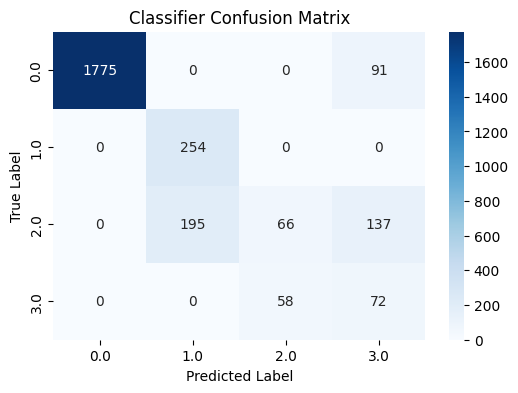

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_test_seq, y_pred_test)
df_cm = pd.DataFrame(cm, index=np.unique(y_test_seq), columns=np.unique(y_test_seq))

plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Classifier Confusion Matrix")
plt.show()

In [17]:
# Define path to save model
model_path = 'BiGRU_model1.keras'
classifier.model.save(model_path)

## Add Classifier Predictions

In [18]:
# Get X and y data for classifier prediction
df_pred = ro_data
X_data = df_pred[filtered_columns]
y_data = df_pred[target_column]

# Create sequences for model input
X_data_seq, y_data_seq = create_sequences(X_data, y_data.values, seq_length)
X_data_seq.shape, y_data_seq.shape

((10124, 5, 10), (10124, 1))

In [19]:
# Add classifier predictions
predictions = best_classifier.predict(X_data_seq)
df_pred.loc[seq_length:, 'Room_Occupancy_Count_Pred'] = predictions
df_pred['Room_Occupancy_Count_Actual'] = y_data[seq_length:]['Room_Occupancy_Count']
df_pred

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,...,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,Datetime,time_diff,is_large_gap,group,Room_Occupancy_Count_Pred,Room_Occupancy_Count_Actual
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,...,0.769231,0,0,1,2017-12-22 10:49:41,NaT,False,1,NaN,NaN
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,...,0.646154,0,0,1,2017-12-22 10:50:12,0 days 00:00:31,False,1,NaN,NaN
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,...,0.519231,0,0,1,2017-12-22 10:50:42,0 days 00:00:30,False,1,NaN,NaN
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,...,0.388462,0,0,1,2017-12-22 10:51:13,0 days 00:00:31,False,1,NaN,NaN
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,...,0.253846,0,0,1,2017-12-22 10:51:44,0 days 00:00:31,False,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10124,2018/01/11,08:58:07,25.06,25.13,24.69,25.31,6,7,33,22,...,0.000000,0,0,0,2018-01-11 08:58:07,0 days 00:00:31,False,3,0.0,0.0
10125,2018/01/11,08:58:37,25.06,25.06,24.69,25.25,6,7,34,22,...,0.000000,0,0,0,2018-01-11 08:58:37,0 days 00:00:30,False,3,0.0,0.0
10126,2018/01/11,08:59:08,25.13,25.06,24.69,25.25,6,7,34,22,...,0.000000,0,0,0,2018-01-11 08:59:08,0 days 00:00:31,False,3,0.0,0.0
10127,2018/01/11,08:59:39,25.13,25.06,24.69,25.25,6,7,34,22,...,0.000000,0,0,0,2018-01-11 08:59:39,0 days 00:00:31,False,3,0.0,0.0


In [20]:
# Export data with predictions
df_pred.to_csv("ro_data_w_both_pred.csv")